In [268]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from gensim.models import Word2Vec

In [269]:
#Đọc dữ liệu
df = pd.read_excel("Films_Data.xlsx")
df.head(5)

,Title,Year,Duration,MPAA,Genres,IMDb_Rating,Director,Stars,Plot_Summary,Image_link
0,Gladiator II,2024,2h 28min,T18,"Action, Adventure, Drama",6.9,Ridley Scott,"Paul Mescal, Denzel Washington, Pedro Pascal",After his home is conquered by the tyrannical ...,https://m.media-amazon.com/images/M/MV5BM2VjZG...
1,Moana 2,2024,1h 40min,P,"Animation, Adventure, Comedy",7.1,David G. Derrick Jr.,"Auli'i Cravalho, Dwayne Johnson, Hualalai Chung",After receiving an unexpected call from her wa...,https://m.media-amazon.com/images/M/MV5BZDUxNT...
2,Gladiator,2000,2h 35min,R,"Action, Adventure, Drama",8.5,Ridley Scott,"Russell Crowe, Joaquin Phoenix, Connie Nielsen",A former Roman General sets out to exact venge...,https://m.media-amazon.com/images/M/MV5BYWQ4Ym...
3,The Substance,2024,2h 21min,R,"Drama, Horror",7.4,Coralie Fargeat,"Demi Moore, Margaret Qualley, Dennis Quaid",A fading celebrity takes a black-market drug: ...,https://m.media-amazon.com/images/M/MV5BMTc2M2...
4,Dear Santa,2024,1h 47min,PG-13,"Comedy, Fantasy, Horror",5.3,Bobby Farrelly,"Jack Black, Robert Timothy Smith, Keegan-Micha...",When a young boy mails his Christmas wish list...,https://m.media-amazon.com/images/M/MV5BMDNjMz...


In [270]:
df.shape

(5455, 10)

In [271]:
df.columns

Index(['Title', 'Year', 'Duration', 'MPAA', 'Genres', 'IMDb_Rating',
       'Director', 'Stars', 'Plot_Summary', 'Image_link'],
      dtype='object')

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5455 entries, 0 to 5454
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         5455 non-null   object 
 1   Year          5455 non-null   int64  
 2   Duration      5455 non-null   object 
 3   MPAA          5353 non-null   object 
 4   Genres        5455 non-null   object 
 5   IMDb_Rating   5455 non-null   float64
 6   Director      5432 non-null   object 
 7   Stars         5433 non-null   object 
 8   Plot_Summary  5432 non-null   object 
 9   Image_link    5455 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 426.3+ KB


In [272]:
def prepare_combined_content(df):
    text_columns = ['Title', 'Genres', 'Director', 'Stars', 'Plot_Summary']
    for col in text_columns:
        df[col] = df[col].fillna('').astype(str).str.lower()
    # Gộp các cột thành một chuỗi duy nhất, kèm theo trọng số IMDb rating
    df['combined_content'] = (
        df['Title'] + ' ' +
        df['Genres'] + ' ' +
        df['Director'] + ' ' +
        df['Stars'] + ' ' +
        df['Plot_Summary']
    )
    return df

def calculate_movie_similarity(df):
    # Chuẩn bị dữ liệu
    df = prepare_combined_content(df)
    
    # Sử dụng CountVectorizer để chuyển đổi văn bản thành vector
    vectorizer = CountVectorizer(stop_words='english')
    content_matrix = vectorizer.fit_transform(df['combined_content'])
    
    # Nhân vector với trọng số IMDb rating để điều chỉnh độ tương đồng
    imdb_weights = df['IMDb_Rating'].values.reshape(-1, 1)
    weighted_matrix = content_matrix.multiply(imdb_weights)
    
    # Tính cosine similarity
    similarity_matrix = cosine_similarity(weighted_matrix)
    
    return similarity_matrix, df, vectorizer

def calculate_movie_score(user_input, df):
    # Tính toán ma trận độ tương đồng
    similarity_matrix, processed_df, vectorizer = calculate_movie_similarity(df)
    
    # Lọc các phim dựa trên input của người dùng
    filtered_df = processed_df.copy()
    
    # Áp dụng các bộ lọc nếu có thông tin
    if user_input.get('Genres'):
        filtered_df = filtered_df[filtered_df['Genres'].str.contains(user_input['Genres'], case=False, na=False)]
    if user_input.get('Director'):
        filtered_df = filtered_df[filtered_df['Director'].str.contains(user_input['Director'], case=False, na=False)]
    if user_input.get('Stars'):
        filtered_df = filtered_df[filtered_df['Stars'].str.contains(user_input['Stars'], case=False, na=False)]
    
    # Nếu có tên phim cụ thể
    if user_input.get('Title'):
        # Tìm index của các phim có tên gần giống
        movie_indices = processed_df[
            processed_df['Title'].str.contains(user_input['Title'], case=False, na=False)
        ].index.tolist()
        
        if movie_indices:
            # Nếu có nhiều phim, lấy phim đầu tiên
            movie_idx = movie_indices[0]
            
            # Lấy điểm tương đồng của phim này với các phim khác
            similarity_scores = similarity_matrix[movie_idx]
            
            # Gán điểm cho các phim trong filtered_df
            filtered_df['score'] = 0.0  # Khởi tạo cột score với giá trị 0
            for orig_idx, score in zip(processed_df.index, similarity_scores):
                # Loại trừ chính phim đang tìm
                if orig_idx in filtered_df.index and orig_idx != movie_idx:
                    filtered_df.loc[orig_idx, 'score'] = score
            
            # Sắp xếp và lấy top 5 phim
            filtered_df = filtered_df[filtered_df.index != movie_idx]  # Loại bỏ phim gốc
            filtered_df = filtered_df.sort_values(by='score', ascending=False).head(5)
    
    # Nếu không có tên phim cụ thể
    else:
        # Tạo vector đại diện cho input
        input_sentence = ' '.join([
            user_input.get('Genres', ''),
            user_input.get('Director', ''),
            user_input.get('Stars', '')
        ])
        
        # Chuyển đổi input thành vector
        input_vector = vectorizer.transform([input_sentence])
        
        # Tính độ tương đồng của input vector với các phim
        input_similarity = cosine_similarity(input_vector, vectorizer.transform(filtered_df['combined_content']))[0]
        
        # Gán điểm cho các phim trong filtered_df
        filtered_df['score'] = input_similarity
        
        # Sắp xếp và lấy top 5 phim
        filtered_df = filtered_df.sort_values(by='score', ascending=False).head(5)
    
    return filtered_df

def display_recommended_movies(user_input, df):
    recommended_movies = calculate_movie_score(user_input, df)
    
    # Thiết lập phông chữ đẹp cho tiêu đề
    font = {'family': 'sans-serif', 'weight': 'bold', 'size': 14}
    
    # Tạo một figure để vẽ hình ảnh
    fig, axs = plt.subplots(1, 5, figsize=(20, 6))  # 5 hình ảnh trên 1 hàng
    fig.subplots_adjust(wspace=0.2)
    
    for i in range(len(recommended_movies)):
        movie = recommended_movies.iloc[i]
        
        # Tải hình ảnh từ URL
        url = movie['Image_link']
        try:
            im = Image.open(requests.get(url, stream=True).raw)
        except:
            axs[i].axis('off')  # Nếu không tải được, để ô trống
            axs[i].set_title(f"{movie['Title']}\nImage not available", fontdict=font, color='gray')
            continue
        
        # Hiển thị hình ảnh
        axs[i].imshow(im)
        axs[i].axis('off')  # Tắt trục
        
        # Thiết lập tiêu đề với rating
        axs[i].set_title(f"{movie['Title']}\nRating: {round(movie['IMDb_Rating'], 1)}", 
                         fontdict=font, color='red', y=-0.18)
    
    # Hiển thị tất cả hình ảnh
    plt.show()



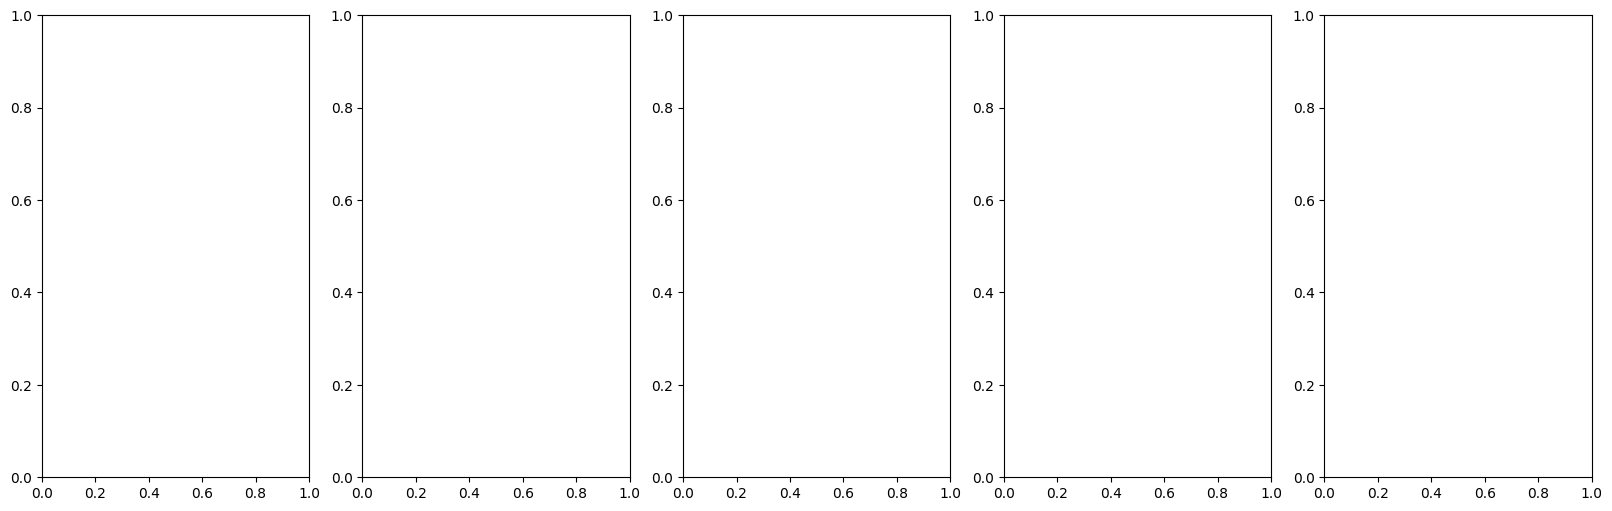

In [137]:
user_input = {
    'Title': "Gladiator II",  # Tìm phim
    'Genres': "Romantic",  # Tìm thể loại 
    'Director': "",  # Tìm đạo diễn
    'Stars': ""  # Tìm diễn viên
}
display_recommended_movies(user_input, df)

In [261]:
import pandas as pd

users = pd.read_excel("/Users/hoangtramanh/Documents/Năm 3 kì 1/KPW/Đề xuất phim/new.xlsx")



In [262]:
users['Reviewer'].unique().shape

(27621,)

In [263]:
users.shape

(49403, 6)

In [264]:
x=users['Reviewer'].value_counts()>5

In [265]:
x[x].shape

(849,)

In [266]:
y=x[x].index
y

Index(['SnoopyStyle', 'ma-cortes', 'claudio_carvalho', 'TheLittleSongbird',
       'bkoganbing', 'kosmasp', 'ccthemovieman-1', 'planktonrules',
       'moonspinner55', 'gavin6942',
       ...
       'Hermit C-2', 'Li-1', 'raymond-15', 'thejdrage', 'cariart',
       'Rex_Stephens', 'Lady_Targaryen', 'AP_FORTYSEVEN', 'fedor8',
       'Blazehgehg'],
      dtype='object', name='Reviewer', length=849)

In [267]:
users[users['Reviewer'].isin(y)]

,Movie,Reviewer,Rating,Review,Likes,Dislikes
0,Buried,grantss,8.0,Paul Conroy (played by Ryan Reynolds) awakes t...,28.0,2
2,Buried,ethanbresnett,7.0,I don't think I've seen a film quite like Buri...,20.0,1
3,Buried,Luigi Di Pilla,7.0,Here is the proof that an intelligent movie ca...,15.0,4
5,Buried,trashgang,6.0,It's a bit hard to review this special movie. ...,44.0,31
7,Buried,classicsoncall,7.0,NaN,7.0,2
...,...,...,...,...,...,...
49375,Internal Affairs,cliftonofun,6.0,The thing about being in your 40s is a movie f...,3.0,0
49379,Internal Affairs,view_and_review,6.0,I've always had a mild to moderate fascination...,3.0,1
49381,Internal Affairs,SnoopyStyle,7.0,Devon Miles (Nick Cannon) is a brash young dru...,4.0,2
49386,Internal Affairs,moviewizguy,7.0,A talented street drummer from Harlem who enro...,7.0,7


In [276]:
num_rating=users.groupby('Movie')['Rating'].count().reset_index()

In [275]:
num_rating.head()

,Movie,num_of_rating
0,'71,20
1,...And Justice for All,20
2,10.000 Năm Trước Công Nguyên,20
3,100 Girls,23
4,101 Chú Chó Đốm,23


In [277]:
num_rating.rename(columns={'Rating':'num_of_rating'}, inplace=True)


In [278]:
num_rating.head()

,Movie,num_of_rating
0,'71,23
1,10 Lives,19
2,"10,000 BC",21
3,100 Girls,23
4,12 Feet Deep,21


Đổi tên movie thành title để merge với bảng df trên

Merge

In [279]:
mer_users_num_rating = users.merge(num_rating, on="Movie", how="left")


In [280]:
mer_users_num_rating

,Movie,Reviewer,Rating,Review,Likes,Dislikes,num_of_rating
0,Buried,grantss,8.0,Paul Conroy (played by Ryan Reynolds) awakes t...,28.0,2,23
1,Buried,offaroundthebend,7.0,NaN,152.0,29,23
2,Buried,ethanbresnett,7.0,I don't think I've seen a film quite like Buri...,20.0,1,23
3,Buried,Luigi Di Pilla,7.0,Here is the proof that an intelligent movie ca...,15.0,4,23
4,Buried,Gerardrobertson61,6.0,When this movie started and the opening credit...,29.0,15,23
...,...,...,...,...,...,...,...
49398,Crossroads,evanston_dad,8.0,"Watching ""Once"" is like sitting in on a jam se...",34.0,1,26
49399,Crossroads,mjjusa-1,10.0,I write these for friends and if you love movi...,604.0,73,26
49400,Crossroads,bzimmer-1,10.0,"I too saw this film at Sundance, and we were t...",227.0,26,26
49401,Crossroads,moutonbear25,9.0,"From the moment ONCE begins, it is clear that ...",61.0,4,26


In [281]:
# Rename 'Movie' to 'Title' in df
df.rename(columns={"Title": "Movie"}, inplace=True)

# Merge based on 'Title'
final_rating = mer_users_num_rating.merge(df, on="Movie")


In [282]:
final_rating.head(5)

,Movie,Reviewer,Rating,Review,Likes,Dislikes,num_of_rating,Year,Duration,MPAA,Genres,IMDb_Rating,Director,Stars,Plot_Summary,Image_link
0,Buried,grantss,8.0,Paul Conroy (played by Ryan Reynolds) awakes t...,28.0,2,23,2010,1h 35min,R,"Drama, Mystery, Thriller",7.0,Rodrigo Cortés,"Ryan Reynolds, José Luis García-Pérez, Robert ...",Paul is a U.S. truck driver working in Iraq. A...,https://m.media-amazon.com/images/M/MV5BOGMxNj...
1,Buried,offaroundthebend,7.0,NaN,152.0,29,23,2010,1h 35min,R,"Drama, Mystery, Thriller",7.0,Rodrigo Cortés,"Ryan Reynolds, José Luis García-Pérez, Robert ...",Paul is a U.S. truck driver working in Iraq. A...,https://m.media-amazon.com/images/M/MV5BOGMxNj...
2,Buried,ethanbresnett,7.0,I don't think I've seen a film quite like Buri...,20.0,1,23,2010,1h 35min,R,"Drama, Mystery, Thriller",7.0,Rodrigo Cortés,"Ryan Reynolds, José Luis García-Pérez, Robert ...",Paul is a U.S. truck driver working in Iraq. A...,https://m.media-amazon.com/images/M/MV5BOGMxNj...
3,Buried,Luigi Di Pilla,7.0,Here is the proof that an intelligent movie ca...,15.0,4,23,2010,1h 35min,R,"Drama, Mystery, Thriller",7.0,Rodrigo Cortés,"Ryan Reynolds, José Luis García-Pérez, Robert ...",Paul is a U.S. truck driver working in Iraq. A...,https://m.media-amazon.com/images/M/MV5BOGMxNj...
4,Buried,Gerardrobertson61,6.0,When this movie started and the opening credit...,29.0,15,23,2010,1h 35min,R,"Drama, Mystery, Thriller",7.0,Rodrigo Cortés,"Ryan Reynolds, José Luis García-Pérez, Robert ...",Paul is a U.S. truck driver working in Iraq. A...,https://m.media-amazon.com/images/M/MV5BOGMxNj...


In [283]:
final_rating.shape

(51598, 16)

In [284]:
final_rating.drop_duplicates(inplace=True)
print(final_rating.shape)


(51598, 16)


In [391]:
FILM_pivot = final_rating.pivot_table(index='Movie', columns='Reviewer', values='Rating', fill_value=0)


In [392]:
FILM_pivot.fillna(0,inplace=True)

In [393]:
all_movies = final_rating['Movie'].unique()
all_movies.shape

(2114,)

In [394]:
FILM_pivot

Reviewer,(M)Rated,00Mike26,00_dexx,04GreatFlick,0w0,1001nights,109YearsOld,10fttall,123dontgo,12_Monkeys,...,zuzuspetals927,zwashington-32756,zweistein,zwrite2,zxgerard,zxjacksterxz,zyxek,zzoaozz,zzza-57262,~AleXa~
Movie,,,,,,,,,,,,,,,,,,,,,
'71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Lives,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"10,000 BC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100 Girls,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Feet Deep,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zapped!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zathura: A Space Adventure,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eXistenZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


TRAINING MODEL

In [395]:
from scipy.sparse import csr_matrix


In [396]:
FILM_sparse = csr_matrix(FILM_pivot)


In [398]:
type(FILM_sparse)


scipy.sparse._csr.csr_matrix

In [399]:
# Now import our clustering algoritm which is Nearest Neighbors this is an unsupervised ml algo
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(algorithm= 'brute')

In [400]:
model.fit(FILM_sparse)


NearestNeighbors(algorithm='brute')

In [355]:
distance, suggestion = model.kneighbors(FILM_pivot.iloc[237,:].values.reshape(1,-1), n_neighbors=6 )


In [356]:
distance


array([[ 0.        , 37.38983819, 37.88139385, 37.89459064, 38.26225294,
        38.82009789]])

In [357]:
suggestion


array([[ 237,  720,   29,  417, 1690, 1426]])

In [401]:
FILM_pivot.iloc[241,:]


Reviewer
(M)Rated        0.0
00Mike26        0.0
00_dexx         0.0
04GreatFlick    0.0
0w0             0.0
               ... 
zxjacksterxz    0.0
zyxek           0.0
zzoaozz         0.0
zzza-57262      0.0
~AleXa~         0.0
Name: Borat Subsequent Moviefilm, Length: 25782, dtype: float64

In [402]:
for i in range(len(suggestion)):
    print(FILM_pivot.index[suggestion[i]])


Index(['Bonnie and Clyde', 'Hubie Halloween', '99 Moons', 'Derailed',
       'The Last Kingdom: Seven Kings Must Die', 'Street Trash'],
      dtype='object', name='Movie')


In [360]:
FILM_pivot.index[3]


'100 Girls'

In [403]:
#keeping books name
FILM_names = FILM_pivot.index


In [405]:
FILM_names[5]


'1492: Conquest of Paradise'

In [363]:
np.where(FILM_pivot.index == '10,000 BC'
)[0][0]


2

FIND URL

In [426]:
# final_rating['title'].value_counts()

ids = np.where(final_rating['Movie'] == "1492: Conquest of Paradise")[0][0]


In [427]:
final_rating.iloc[ids]['Image_link']

'https://m.media-amazon.com/images/M/MV5BZDZjYTcxMDYtZjY0NS00MzgxLTk4MzMtMzQzZDk0M2IxMDFjXkEyXkFqcGc@._V1_QL75_UX280_CR0,2,280,414_.jpg'

In [428]:
FILM_name = []
for FILM_id in suggestion:
    FILM_name.append(FILM_pivot.index[FILM_id])


In [429]:
FILM_name[0]

Index(['Bonnie and Clyde', 'Hubie Halloween', '99 Moons', 'Derailed',
       'The Last Kingdom: Seven Kings Must Die', 'Street Trash'],
      dtype='object', name='Movie')

In [411]:
ids_index = []
for name in FILM_name[0]: 
    ids = np.where(final_rating['Movie'] == name)[0][0]
    ids_index.append(ids)

In [430]:
for idx in ids_index:
    url = final_rating.iloc[idx]['Image_link']
    print(url)

https://m.media-amazon.com/images/M/MV5BYWI3ZmM1NmEtMDk4Yi00MzYzLTk0MDctYWJlZjY4MGViNDFiXkEyXkFqcGc@._V1_QL75_UX280_CR0,5,280,414_.jpg
https://m.media-amazon.com/images/M/MV5BZTlkMDdiNmUtOTQwYS00ZTE5LWJlMWEtNzMyN2M2MWIzZTMzXkEyXkFqcGc@._V1_QL75_UY414_CR26,0,280,414_.jpg
https://m.media-amazon.com/images/M/MV5BM2Q3NDkyZDctZDEyMi00YjNhLWI5OTctMjIxNDQ4ZDQyZThkXkEyXkFqcGc@._V1_QL75_UY414_CR5,0,280,414_.jpg
https://m.media-amazon.com/images/M/MV5BNTBiYTkxNTItZDE1Ni00ZjZmLWFiNTAtMTFmZjIzNTU0YTJiXkEyXkFqcGc@._V1_QL75_UY414_CR0,0,280,414_.jpg
https://m.media-amazon.com/images/M/MV5BZmQzMTMwOTItYjUyMS00NDY4LThmOWEtZjE3ODkyMzg3MDdlXkEyXkFqcGc@._V1_QL75_UY414_CR2,0,280,414_.jpg
https://m.media-amazon.com/images/M/MV5BZjk3Mjk2YjUtY2YxZS00YWExLWE3ZGYtMDA3MGM2ZmIzZTIxXkEyXkFqcGc@._V1_QL75_UX280_CR0,4,280,414_.jpg


In [413]:
import os
import pickle

# Create the 'artifacts' directory if it doesn't exist
if not os.path.exists('model'):
    os.makedirs('model')

import pickle

# Saving the model, FILM_names, final_rating, and FILM_pivot
pickle.dump(model, open('model/model.pkl', 'wb'))
pickle.dump(FILM_names, open('model/FILM_names.pkl', 'wb'))
pickle.dump(final_rating, open('model/final_rating.pkl', 'wb'))
pickle.dump(FILM_pivot, open('model/FILM_pivot.pkl', 'wb'))  # Save FILM_pivot DataFrame


TESTING MODEL

In [424]:
FILM_pivot.shape

(2114, 25782)

In [431]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_FILM(FILM_name):
    # Chuẩn hóa tên bộ phim (loại bỏ khoảng trắng và chuyển về chữ thường)
    FILM_name = FILM_name.strip().lower()

    # Kiểm tra xem bộ phim có tồn tại trong dữ liệu không
    # Convert index to lowercase to match the input FILM_name
    FILM_pivot_lower = FILM_pivot.index.str.lower()

    if FILM_name not in FILM_pivot_lower:
        print(f"Bộ phim '{FILM_name}' không có trong tập dữ liệu.")
        return

    # Tìm vị trí của bộ phim trong bảng
    FILM_id = FILM_pivot_lower.get_loc(FILM_name)  # Sử dụng get_loc thay vì np.where
    
    # Tính toán vector tương đồng
    FILM_vector = FILM_pivot.iloc[FILM_id, :].values.reshape(1, -1)
    similarity_scores = cosine_similarity(FILM_pivot.values, FILM_vector).flatten()

    # Lấy 5 phim tương đồng nhất (ngoại trừ chính bộ phim đó)
    top_n = 5
    similar_indices = similarity_scores.argsort()[-top_n-1:-1][::-1]  # Lấy top 6 (trừ chính nó)

    print(f"Bạn đã tìm kiếm: '{FILM_name}'\n")
    print("Các gợi ý phim là:\n")
    for idx in similar_indices:
        print(FILM_pivot.index[idx])

# Test với một bộ phim
FILM_name = "Buried"  # Đảm bảo tên phim nhập vào đúng
recommend_FILM(FILM_name)


Bạn đã tìm kiếm: 'buried'

Các gợi ý phim là:

Peppermint
Books of Blood
Entergalactic
The Sea Beast
Spin Me Round


In [ ]:
pip install scikit-surprise


In [376]:
mean_rating = final_rating['Rating'].mean()
final_rating['Rating'] = final_rating['Rating'].fillna(mean_rating)


In [377]:
final_rating['MPAA'] = final_rating['MPAA'].fillna('Unknown')


In [378]:
final_rating['Review'] = final_rating['Review'].fillna('')
final_rating['Likes'] = final_rating['Likes'].fillna(0)
final_rating['Dislikes'] = final_rating['Dislikes'].fillna(0)


In [379]:
print(final_rating.isnull().sum())  # Kiểm tra các giá trị thiếu


Movie              0
Reviewer          47
Rating             0
Review             0
Likes              0
Dislikes           0
num_of_rating      0
Year               0
Duration           0
MPAA               0
Genres             0
IMDb_Rating        0
Director         185
Stars            185
Plot_Summary     185
Image_link         0
dtype: int64


In [420]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(final_rating[['Reviewer', 'Movie', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

model = SVD()
model.fit(trainset)

predictions = model.test(testset)
mae = accuracy.mae(predictions)
rmse = accuracy.rmse(predictions)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE:  nan
RMSE: nan
MAE: nan
RMSE: nan
